In [1]:
!pip install git+https://github.com/konstmish/opt_methods.git

  Cloning https://github.com/konstmish/opt_methods.git to /private/var/folders/85/16bzmhwj69q5ml84_p5zhkvd0m4sgy/T/pip-req-build-hpinglqe
  Running command git clone -q https://github.com/konstmish/opt_methods.git /private/var/folders/85/16bzmhwj69q5ml84_p5zhkvd0m4sgy/T/pip-req-build-hpinglqe
  Resolved https://github.com/konstmish/opt_methods.git to commit 716a0ed61c978ea1b8a2b8253a5a9646ff76aa4e


In [2]:
!pip install -U ray

In [3]:
import ray
import copy
import scipy
import pickle
import psutil
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.ticker
import numpy.linalg as la
import matplotlib.pyplot as plt

import sklearn.datasets
import urllib.request

import matplotlib.image as mpimg

from scipy.stats import expon
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.datasets import load_svmlight_file, fetch_rcv1

from optmethods.datasets import get_dataset
from optmethods.loss import LogisticRegression
from optmethods.optimizer import StochasticOptimizer
from optmethods.utils import get_trace, relative_round
from optmethods.first_order import Adgd, Gd, Nesterov, RestNest

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

# ProxSkip

In [4]:
class ProxSkip(StochasticOptimizer):
    """
    Stochastic gradient descent with decreasing or constant learning rate.
    
    Arguments:
        lr (float, optional): an estimate of the inverse smoothness constant
        lr_decay_coef (float, optional): the coefficient in front of the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value
            is mu/2, where mu is the strong convexity constant
        lr_decay_power (float, optional): the power to exponentiate the number of finished iterations
            in the denominator of step-size. For strongly convex problems, a good value is 1 (default: 1)
        it_start_decay (int, optional): how many iterations the step-size is kept constant
            By default, will be set to have about 2.5% of iterations with the step-size equal to lr0
        batch_size (int, optional): the number of samples from the function to be used at each iteration
    """
    def __init__(self, it_local, n_workers=None, q=None, grad_time=None, com_time=1, cohort_size=None, iid=False, lr0=None, lr_max=np.inf, lr_decay_coef=0,
                 lr_decay_power=1, it_start_decay=None, batch_size=1, losses=None, *args, **kwargs):
        super(ProxSkip, self).__init__(*args, **kwargs)
        self.it_local = it_local
        if n_workers is None:
            n_workers = psutil.cpu_count(logical=False)
        if cohort_size is None:
            cohort_size = n_workers
        self.n_workers = n_workers
        self.cohort_size = cohort_size
        self.iid = iid
        self.lr0 = lr0
        self.lr_max = lr_max
        self.lr_decay_coef = lr_decay_coef
        self.lr_decay_power = lr_decay_power
        self.it_start_decay = it_start_decay
        self.batch_size = batch_size
        self.losses = losses
        self.trace.hs = []
        self.q = [1]*self.n_workers if q is None else q
        self.grad_skip = False if q is None else True
        self.grad_time = [1]*self.n_workers if grad_time is None else grad_time
        self.com_time = com_time

             
    def step(self):
        denom_const = 1 / self.lr0
        lr_decayed = 1 / (denom_const + self.it_local*self.lr_decay_coef*max(0, self.it-self.it_start_decay)**self.lr_decay_power)
        if lr_decayed < 0:
            lr_decayed = np.inf
        self.lr = min(lr_decayed, self.lr_max)
        x_id = ray.put(self.x)
        
        if self.cohort_size == self.n_workers:
            self.x = np.mean(ray.get([worker.run_local.remote(x_id, self.lr) for worker in self.workers]), axis=0)
            self.h = ray.get([worker.get_h.remote() for worker in self.workers])       
        else:
            cohort = np.random.choice(self.n_workers, self.cohort_size, replace=False)
            self.x = np.mean(ray.get([self.workers[i].run_local.remote(x_id, self.lr) for i in cohort]), axis=0)
            self.h = ray.get([worker.get_h.remote() for worker in self.workers])       
    
    def init_run(self, *args, **kwargs):
        super(ProxSkip, self).init_run(*args, **kwargs)
        if self.it_start_decay is None and np.isfinite(self.it_max):
            self.it_start_decay = self.it_max // 40 if np.isfinite(self.it_max) else 0
        if self.lr0 is None:
            self.lr0 = 1 / self.loss.batch_smoothness(batch_size)
        if self.iid:
            loss_id = ray.put(self.loss)
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, grad_skip=self.grad_skip,
                                          q=self.q[i], grad_time=self.grad_time[i], com_time=self.com_time, 
                                          loss=loss_id, it_local=self.it_local, batch_size=self.batch_size) 
                            for i in range(self.n_workers)]
        else:
            loss_ids = [ray.put(self.losses[i]) for i in range(self.n_workers)]
            self.workers = [Worker.remote(shuffle=False, prox_skip=True, grad_skip=self.grad_skip,
                                          q=self.q[i], grad_time=self.grad_time[i], com_time=self.com_time,
                                          loss=loss, it_local=self.it_local, batch_size=self.batch_size)
                            for i, loss in enumerate(loss_ids)]
        
    def update_trace(self, first_iterations=10):
        super(ProxSkip, self).update_trace()
        self.trace.hs.append(copy.deepcopy(self.h))
        
    def get_workers_time(self):
        '''python list of size (n_workers, it_max)'''
        return self.workers_time
        
    def get_communication_time(self):
        '''python list of size it_max = #communications'''
        return np.amax(self.get_workers_time(), axis = 0)
        
    def get_total_time(self):
        return sum(self.get_communication_time())
        
    def get_workers_steps(self):
        '''python list of size (n_workers, it_max)'''
        return self.workers_steps
            
    def terminate_workers(self):
        self.workers_steps = ray.get([worker.get_steps.remote() for worker in self.workers])
        self.workers_time = ray.get([worker.get_time.remote() for worker in self.workers])
        for worker in self.workers:
            ray.kill(worker)
        ray.shutdown()
        self.workers = None # without this there is a problem saving objects of ProxSkip class into pickle
        

# Worker

In [5]:
@ray.remote
class Worker:
    def __init__(self, shuffle=True, prox_skip=False, grad_skip=False, q=1, grad_time=1, com_time=1, loss=None, it_local=None, batch_size=1):
        self.loss = loss
        self.shuffle = shuffle
        self.prox_skip = prox_skip
        self.grad_skip = grad_skip
        self.it_local = it_local
        self.batch_size = batch_size
        self.c = None
        self.h = None
        self.rng_skip = np.random.default_rng(42) # random number generator for random synchronizations
        self.q = q
        self.grad_time = grad_time
        self.com_time = com_time
        self.steps = [0]
        self.time = [0]
    
    def run_local(self, x, lr):
        self.x = x * 1.
        if self.shuffle:
            self.run_local_shuffle(lr)
        elif self.prox_skip:
            self.run_prox_skip(lr)
            if self.grad_skip:
                return self.x - lr*self.it_local*self.h
        else:
            self.run_local_sgd(lr)
        return self.x
    
    def run_local_shuffle(self, lr):
        permutation = np.random.permutation(self.loss.n)
        i = 0
        while i < self.loss.n:
            i_max = min(self.loss.n, i + self.batch_size)
            idx = permutation[i:i_max]
            self.x -= lr * self.loss.stochastic_gradient(self.x, idx=idx)
            i += self.batch_size
    
    def run_local_sgd(self, lr):
        for i in range(self.it_local):
            if self.batch_size is None:
                self.x -= lr * self.loss.gradient(self.x)
            else:
                self.x -= lr * self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
   
    def run_scaffold(self, x, lr, c):
        # as in the original scaffold paper, we use their Option II
        self.x = x * 1.
        if self.c is None:
            self.c = self.x * 0. #initialize zero vector of the same dimension
        for i in range(self.it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.c + c)
        self.c += 1 / (self.it_local * lr) * (x - self.x) - c
        return self.x
    
    def run_prox_skip(self, lr):
        p = 1 / self.it_local
        if self.h is None:
            # first iteration
            self.h = self.x * 0. # initialize zero vector of the same dimension
        else:
            # update the gradient estimate 
            self.h += p / lr * (self.x - self.x_before_averaing)
            
        it_local = self.rng_skip.geometric(p) # since all workers use the same random seed, this number is the same for all of them

        f = False
        if self.grad_skip:
                
            it_q = np.inf if self.q == 1 else np.random.geometric(1-self.q)
        
            if it_q <= it_local:
                it_local = it_q - 1
                f = True
        
        for i in range(it_local):
            if self.batch_size is None:
                g = self.loss.gradient(self.x)
            else:
                g = self.loss.stochastic_gradient(self.x, batch_size=self.batch_size)
            self.x -= lr * (g - self.h)
            
        if self.grad_skip and f:
            self.h = self.loss.gradient(self.x)
            it_local += 1
            
        self.x_before_averaing = self.x * 1.
        
        self.steps.append(it_local)
        self.time.append(it_local*self.grad_time + self.com_time)
        
    def get_control_var(self):
        return self.c
    
    def get_steps(self):
        return self.steps
    
    def get_time(self):
        return self.time
    
    def get_h(self):
        return self.h
    
    def get_g(self):
        return self.g
    
    def get(self, x):
        if self.batch_size is None:
            self.g = self.loss.gradient(x)
        else:
            self.g = self.loss.stochastic_gradient(x, batch_size=self.batch_size)
        return self.g

# Saving dictionaries

In [6]:
def update_prox_dict(prox_key, prox):
    prox_skip = get_prox_dict()
    prox_skip[prox_key] = prox
    with open('./Pickles/ProxSkip_dict.pkl', 'wb') as outp:
        pickle.dump(prox_skip, outp, pickle.HIGHEST_PROTOCOL)
        
def get_prox_dict():
    try:
        with open('./Pickles/ProxSkip_dict.pkl', 'rb') as inp:
            prox_skip = pickle.load(inp)
    except FileNotFoundError:
        prox_skip = {}
    return prox_skip
    
    
def update_grad_dict(grad_key, grad):
    grad_skip = get_grad_dict()
    grad_skip[grad_key] = grad
    with open('./Pickles/GradSkip_dict.pkl', 'wb') as outp:
        pickle.dump(grad_skip, outp, pickle.HIGHEST_PROTOCOL)
        
def get_grad_dict():
    try:
        with open('./Pickles/GradSkip_dict.pkl', 'rb') as inp:
            grad_skip = pickle.load(inp)
    except FileNotFoundError:
        grad_skip = {}
    return grad_skip
        
def update_L_dict(L_key, l):
    L = get_L_dict()
    L[L_key] = l
    with open('./Pickles/L_dict.pkl', 'wb') as outp:
        pickle.dump(L, outp, pickle.HIGHEST_PROTOCOL)
        
def get_L_dict():
    try:  
        with open('./Pickles/L_dict.pkl', 'rb') as inp:
            L = pickle.load(inp)
    except FileNotFoundError:
        L = {}
    return L

def update_l2_dict(l2_key, l2_new):
    l2 = get_l2_dict()
    l2[l2_key] = l2_new
    with open('./Pickles/l2_dict.pkl', 'wb') as outp:
        pickle.dump(l2, outp, pickle.HIGHEST_PROTOCOL)
        
def get_l2_dict():
    try:  
        with open('./Pickles/l2_dict.pkl', 'rb') as inp:
            l2 = pickle.load(inp)
    except FileNotFoundError:
        l2 = {}
    return l2

# Generate artificial data and run methods

In [7]:
def generate_L(n, L_max=None, bins=None, power=None, exponent=None):
    if power:
        L = [i**power for i in range(1, n+1)]
    elif exponent:
        L = [exponent**i for i in range(1, n+1)]
    else:
        L = np.concatenate([np.random.uniform(bins[i], bins[i+1], size = ni) for i,ni in enumerate(n)])
        L[L==L.max()] = L_max
        
    # L = expon.rvs(scale=10, size=n_workers)
    # L = np.random.uniform(10, 100, size=n_workers)
    # L = np.random.normal(10, 100, n_workers)
    # L = abs(L)
    # L = np.random.uniform(0, 10000, size = n_workers)  
        
    return np.array(L)

In [8]:
def generate_artificial_data(m, d, l2, L_max=None, n=None, L=None, bins=None, power=None, exponent=None):
    if L is None:
        L = generate_L(n=n, L_max=L_max, bins=bins, power=power, exponent=exponent)
        
    L = np.sqrt(4*L*m - 4*l2*m)  
    n_workers = len(L)
    
    # generation of A for each device
    A = []
    b = []
    for i in range(n_workers):
        D = np.random.rand(min(m,d)) 
        D -= np.min(D)
        D /= np.max(D)
        D = D * L[i]
        M = np.zeros([m,d])
        M[:min(m,d), :min(m,d)] = np.diag(D)
        U, _ = np.linalg.qr(np.random.rand(m,m))
        V, _ = np.linalg.qr(np.random.rand(d,d))
        A.append(U @ M @ V)
        b.append(np.random.randint(2, size=m))
    
    return A, b

In [9]:
def generate_and_run(m, d, l2, it_max, q='optimal', L_max=None, n=None, L=None, bins=None, power=None, exponent=None):
    A, b = generate_artificial_data(n=n, m=m, d=d, l2=l2, L=L, L_max=L_max, bins=bins, power=power, exponent=exponent)
    n_workers = len(A)
    loss = LogisticRegression(np.concatenate(A), np.concatenate(b), l1=0, l2=l2)
    losses = []
    for i in range(n_workers):
        loss_i = LogisticRegression(A[i], b[i], l1=0, l2=l2)
        losses.append(loss_i)
    L = [loss.smoothness for loss in losses]
    L_max = max(L)
    
    x0 = np.zeros(d)

    # Solve problem by Nesterov's method to find loss.f_opt
    rest = RestNest(loss=loss, doubling=True)
    rest.run(x0=x0, it_max=1000000)
    rest.compute_loss_of_iterates()
    rest.trace.plot_losses()
    plt.yscale('log')
    plt.show()
    
    it_local = (L_max/l2)**0.5
    p = 1 / it_local
    skip_lr0 = 1 / L_max
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize
    n_seeds = 1
    batch_size = None
    cohort_size = None
    
    ray.shutdown()
    ray.init(num_cpus=num_cpus)
    prox = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr0, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=it_max+10, iid=False, losses=losses)
    prox.run(x0=x0, it_max=it_max)
    prox.trace.compute_loss_of_iterates()
    prox.terminate_workers()
    
    if q == 'optimal':
        q = [(1 - l2/li) / ( 1-p**2 ) for li in L]
        
    ray.shutdown()
    ray.init(num_cpus=num_cpus)
    grad = ProxSkip(loss=loss, n_workers=n_workers, q=q, it_local=it_local, 
               lr_max=skip_lr0, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=it_max+10, iid=False, losses=losses)
    grad.run(x0=x0, it_max=it_max)
    grad.trace.compute_loss_of_iterates()
    grad.terminate_workers()
    
    return prox, grad, L

# Get real data and run methods

In [10]:
def get_data(name):
    data_path = f'./Datasets/{name}'
    
    data_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{name}"
    f = urllib.request.urlretrieve(data_url, data_path)
    
    A, b = sklearn.datasets.load_svmlight_file(data_path)
    
    num_cpus = psutil.cpu_count(logical=False)
    n, _ = A.shape
    if n % num_cpus != 0:
        A = A[:n - (n % num_cpus)]
        b = b[:n - (n % num_cpus)]
    b_unique = np.unique(b)
    if (b_unique == [1, 2]).all():
        # Transform labels {1, 2} to {0, 1}
        b = b - 1
    elif (b_unique == [-1, 1]).all():
        # Transform labels {-1, 1} to {0, 1}
        b = (b+1) / 2
    else:
        # replace class labels with 0's and 1's
        b = 1. * (b == b[0])
        
    return A, b

In [11]:
def get_and_run(name, n_workers, it_max, q='optimal', grad_time='optimal', com_time=1):
    A, b = get_data(name)
    
    n, d = A.shape
    if n % n_workers != 0:
        A = A[:n - (n % n_workers)]
        b = b[:n - (n % n_workers)]
        n -= n % n_workers
        
    losses = []
    permutation = b.squeeze().argsort()
    idx = [0] + [(n * i) // n_workers for i in range(1, n_workers)] + [n]
    for i in range(n_workers):
        idx_i = permutation[idx[i] : idx[i+1]]
        loss_i = LogisticRegression(A[idx_i], b[idx_i], l1=0, l2=0)
        losses.append(loss_i)

    L = [loss.smoothness for loss in losses]
    L_max = max(L)
#     l2 = L_max/(1e4-1)
    l2 = 1e-4*L_max
    
    for i in range(n_workers):
        losses[i].l2 = l2
        losses[i]._smoothness = None
    
    loss = LogisticRegression(A, b, l1=0, l2=l2)
        
    L = [loss.smoothness for loss in losses]
    L_max = max(L)
    
    x0 = np.zeros(d)

    # Solve problem by Nesterov's method to find loss.f_opt
    rest = RestNest(loss=loss, doubling=True)
    rest.run(x0=x0, it_max=1000000)
    rest.compute_loss_of_iterates()
    rest.trace.plot_losses()
    plt.yscale('log')
    plt.show() # to make sure that it converged to the solution

    it_local = (L_max/l2)**0.5
    p = 1 / it_local
    skip_lr0 = 1 / L_max
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize
    n_seeds = 1
    batch_size = None
    cohort_size = None
    
    if grad_time == 'optimal':
        grad_time = [(p + l2/L[i])/(p+l2/min(L)) for i in range(n_workers)]
    
    ray.shutdown()
    ray.init(num_cpus=num_cpus)
    prox = ProxSkip(loss=loss, n_workers=n_workers, grad_time=grad_time, com_time=com_time, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr0, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=it_max+10, iid=False, losses=losses)
    prox.run(x0=x0, it_max=it_max)
    prox.trace.compute_loss_of_iterates()
    prox.terminate_workers()
    
    if q == 'optimal':
        q = [(1 - l2/l) / ( 1-p**2 ) for l in L]
    
#     skip_lr0 = min([(1/L[i]) * ( p**2 / (1-qi*(1-p**2)) ) for i, qi in enumerate(q)])
    
    ray.shutdown()
    ray.init(num_cpus=num_cpus)
    grad = ProxSkip(loss=loss, n_workers=n_workers, q=q, grad_time=grad_time, com_time=com_time, it_local=it_local, 
               lr_max=skip_lr0, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=it_max+10, iid=False, losses=losses)
    grad.run(x0=x0, it_max=it_max)
    grad.trace.compute_loss_of_iterates()
    grad.terminate_workers()
    
    return prox, grad, L, l2


# General params

In [12]:
np.random.seed(0)
num_cpus = psutil.cpu_count(logical=False)
l2_artificial = 1e-1
d = 200
m = 300

# Run L_max

1.0


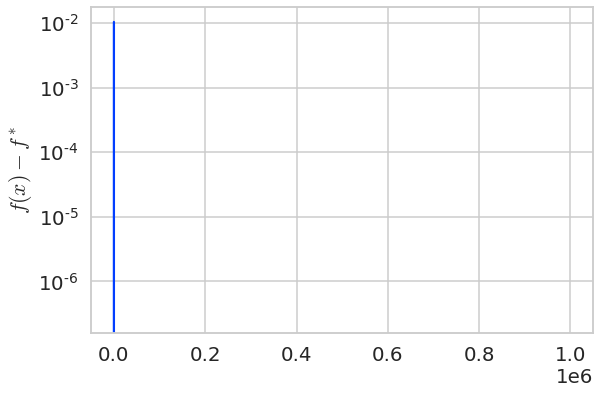

2022-10-16 15:48:28,601	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 15:49:37,678	INFO worker.py:1518 -- Started a local Ray instance.


10.0


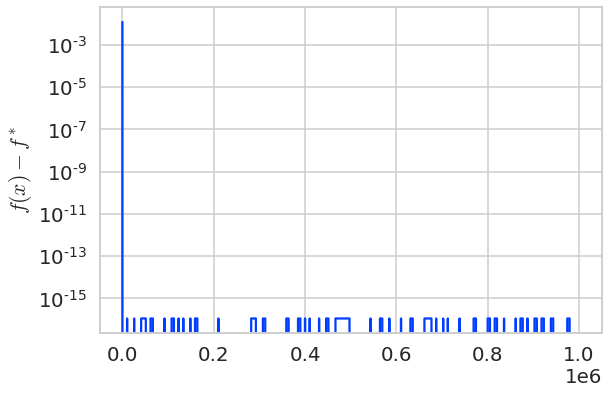

2022-10-16 15:58:59,674	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 16:00:10,498	INFO worker.py:1518 -- Started a local Ray instance.


100.0


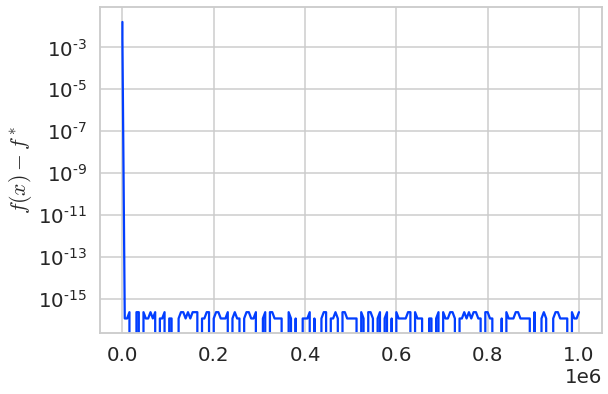

2022-10-16 16:09:27,013	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 16:10:52,562	INFO worker.py:1518 -- Started a local Ray instance.


1000.0


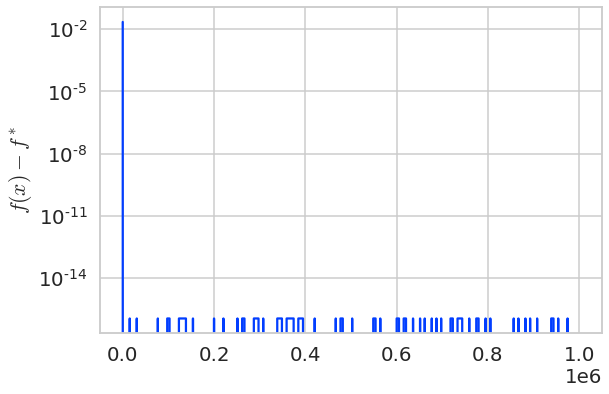

2022-10-16 16:20:12,384	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 16:22:18,086	INFO worker.py:1518 -- Started a local Ray instance.


10000.0


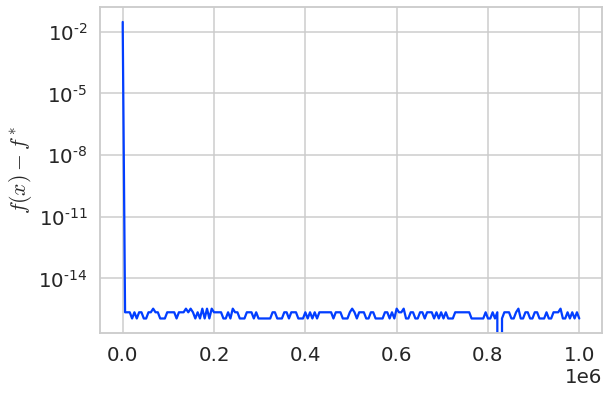

2022-10-16 16:32:01,980	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 16:36:32,943	INFO worker.py:1518 -- Started a local Ray instance.


100000.0


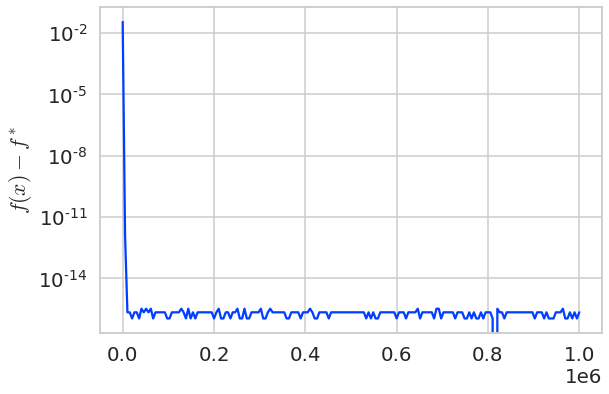

2022-10-16 16:46:42,133	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 16:57:25,709	INFO worker.py:1518 -- Started a local Ray instance.


1000000.0


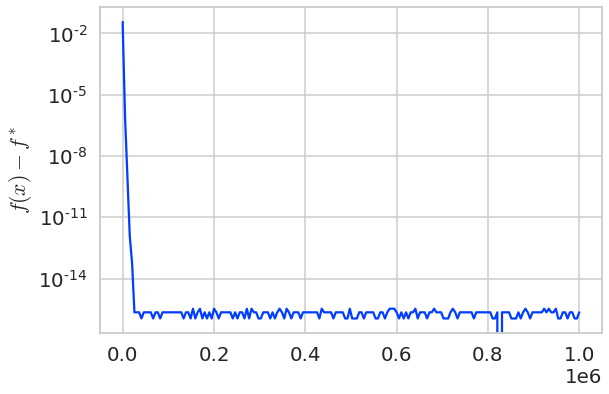

2022-10-16 17:08:27,287	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 17:39:26,783	INFO worker.py:1518 -- Started a local Ray instance.


10000000.0


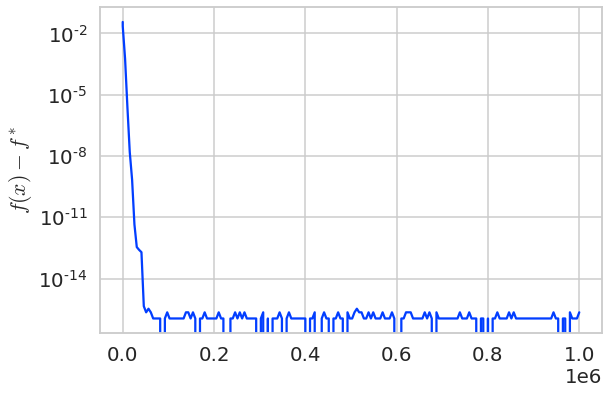

2022-10-16 17:54:41,209	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 20:11:32,611	INFO worker.py:1518 -- Started a local Ray instance.


In [13]:
L_maxes = [1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
it_max_L = 3000

if it_max_L:
    for L_max in L_maxes:
        print(L_max)
        L_max = round(L_max)
        L = np.append(1 - np.random.uniform(0, 1-l2_artificial, size = 19), L_max)
        prox, grad, l = generate_and_run(L=L, m=m, d=d, l2=l2_artificial, it_max=it_max_L)
        update_prox_dict(f'L_max={L_max}', prox)
        update_grad_dict(f'L_max={L_max}', grad)
        update_L_dict(f'L_max={L_max}', l)

# Run n

2


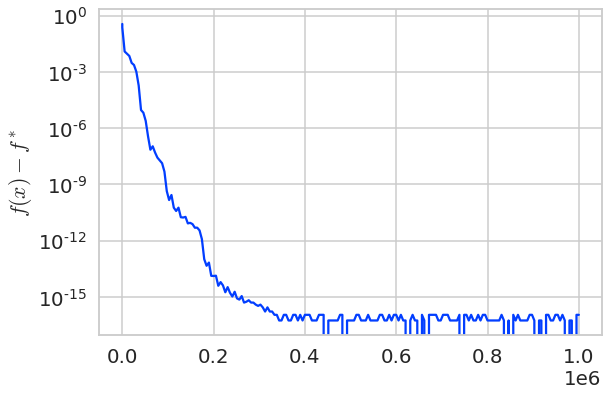

2022-10-16 20:33:25,437	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 20:53:26,378	INFO worker.py:1518 -- Started a local Ray instance.


4


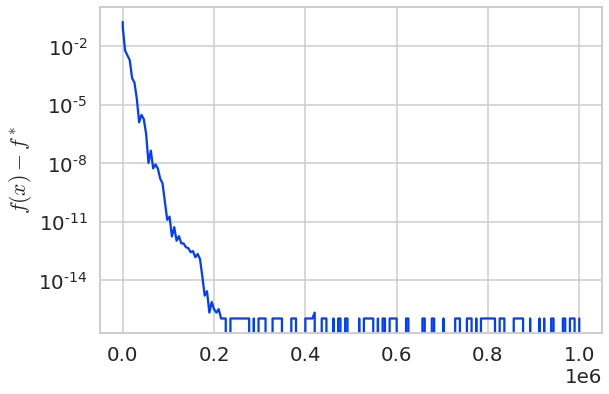

2022-10-16 21:15:09,628	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 21:37:37,275	INFO worker.py:1518 -- Started a local Ray instance.


8


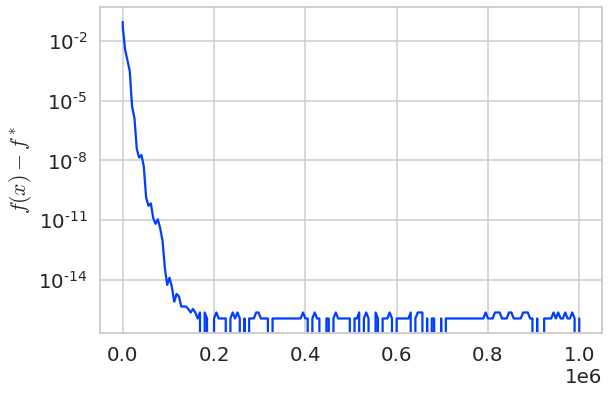

2022-10-16 22:01:01,574	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-16 22:38:40,509	INFO worker.py:1518 -- Started a local Ray instance.


16


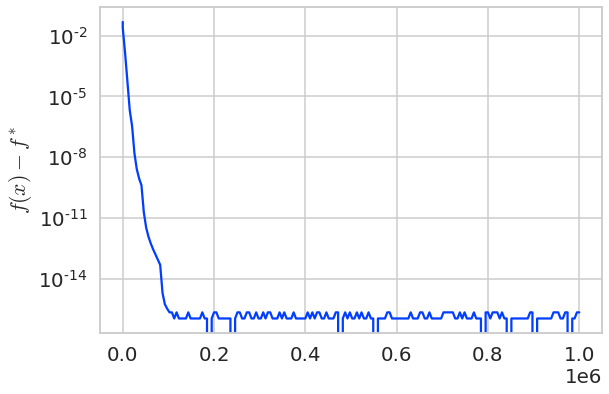

2022-10-16 23:04:27,122	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 00:20:30,557	INFO worker.py:1518 -- Started a local Ray instance.


32


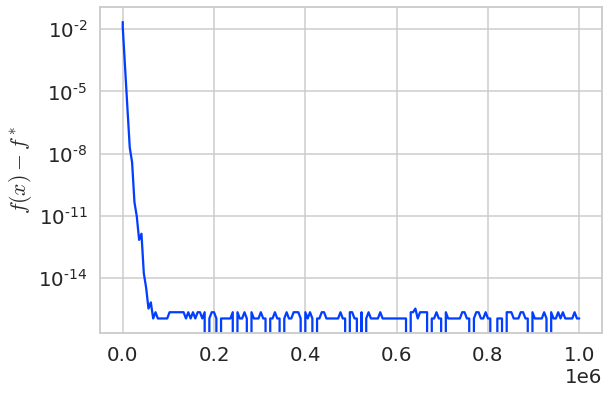

2022-10-17 00:55:57,134	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 00:56:11,709	WARNING worker.py:1829 -- WARNING: 32 PYTHON worker processes have been started on node: 35b7414f3ac485f57c1fb89bcc2e33d3d6f8808f7709bda3188c7508 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-10-17 00:56:12,541	WARNING worker.py:1829 -- WARNING: 40 PYTHON worker processes have been started on node: 35b7414f3ac485f57c1fb89bcc2e33d3d6f8808f7709bda3188c7508 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-10-17 03:13:39,581	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 03:13:51,647	WARNING worker.py:1829 -- WARNING: 34 PYTHON worker 

64


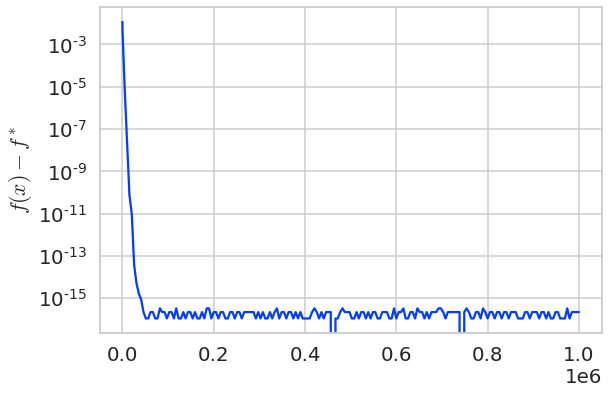

2022-10-17 04:01:14,142	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 04:01:27,277	WARNING worker.py:1829 -- WARNING: 33 PYTHON worker processes have been started on node: 63950f691a577539ad3d3b9e2a89317b18d53e17c5b57f60f34cd4a3 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-10-17 04:01:28,966	WARNING worker.py:1829 -- WARNING: 40 PYTHON worker processes have been started on node: 63950f691a577539ad3d3b9e2a89317b18d53e17c5b57f60f34cd4a3 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2022-10-17 04:01:32,101	WARNING worker.py:1829 -- WARNING: 48 PYTHON worker processes have been started on node: 63950f691a577539ad3d3b9e2a89317b18d53e17

In [14]:
ns = [2,4,8,16,32,64]
it_max_n = 3000

if it_max_n:
    for n in ns:
        print(n)
        L = np.append(1 - np.random.uniform(0, 1-l2_artificial, size = n-1), 1e7)
        prox, grad, l = generate_and_run(L=L, m=m, d=d, l2=l2_artificial, it_max=it_max_n)
        update_prox_dict(n, prox)
        update_grad_dict(n, grad)
        update_L_dict(n, l)

# Run time

time=1


/Users/maranja/opt/anaconda3/lib/python3.9/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


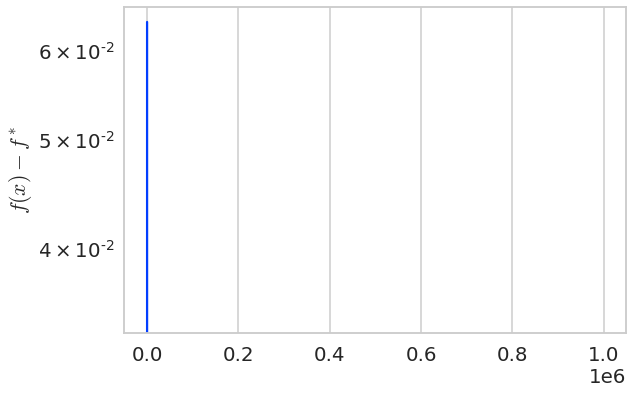

2022-10-17 09:34:51,619	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 09:35:32,641	INFO worker.py:1518 -- Started a local Ray instance.


time=random


/Users/maranja/opt/anaconda3/lib/python3.9/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


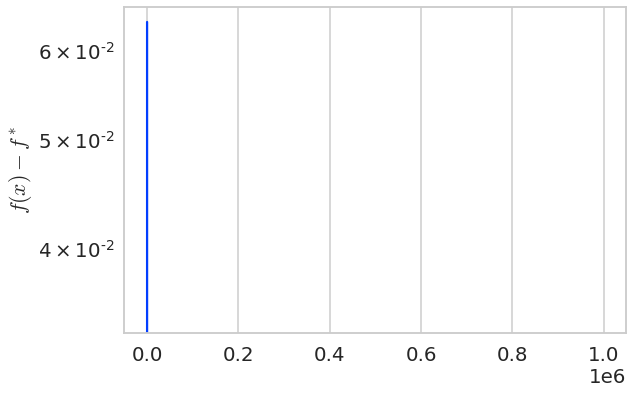

/var/folders/85/16bzmhwj69q5ml84_p5zhkvd0m4sgy/T/ipykernel_73684/2857404239.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if grad_time == 'optimal':
2022-10-17 09:37:36,543	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 09:38:14,420	INFO worker.py:1518 -- Started a local Ray instance.


time=optimal


/Users/maranja/opt/anaconda3/lib/python3.9/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


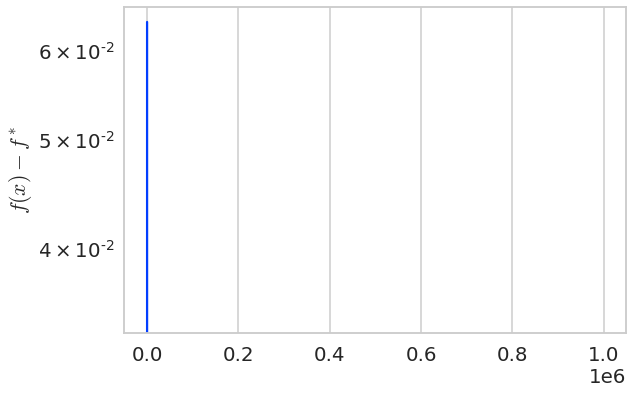

2022-10-17 09:40:24,569	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-17 09:41:03,839	INFO worker.py:1518 -- Started a local Ray instance.


In [15]:
n_workers = 5
grad_times = [
    ('time=1', [1] * n_workers),
    ('time=random', 1 - np.random.uniform(0,1, size=n_workers)),
    ('time=optimal', 'optimal'),
]

it_max_time = 2000

if it_max_time:
    for key, grad_time in grad_times:
        print(key)
        prox, grad, l, l2 = get_and_run(name='australian', n_workers=n_workers, grad_time=grad_time, it_max=it_max_time)
        update_prox_dict(f'{key}', prox)
        update_grad_dict(f'{key}', grad)
        update_L_dict(f'{key}', l)
        update_l2_dict(f'{key}', l2)

# Plots

In [16]:
def plot_strip(L, xticks, xlim, save_as=None, size1=10, alpha=0.5, size2=15, save=True):
    ax = sns.stripplot(x=sorted(L)[:-1], color='orange', size=size1, jitter=0.47, alpha=alpha)
    ax = sns.stripplot(x=[max(L)], color='orange', size=size2)
# ax = sns.boxplot(x=np.append(np.random.uniform(2*l2, 1, size = 19), 1e6), showcaps=False,boxprops={'facecolor':'None'},
#         showfliers=False,whiskerprops={'linewidth':0})
    plt.xscale('log')
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.title(fr'$n={len(L)}$, ' + r'$L_{max}= $' + fr'$10^{int(np.log10(max(L) + 1))}$')
    plt.xlabel(r'$L_i$')
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/strip_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/strip_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [17]:
def plot_histogram(L, n, save_as=None, save=True):
    if save_as is None:
        save_as = n
    plt.hist(L, bins=bins, color='orange')
    plt.xscale('log')
    plt.xlabel(r'$L_i$')
    plt.ylabel('Frequency')
    ticks = set(n)
    ticks.discard(0)
    plt.yticks(sorted(list(ticks)))
    plt.vlines(x = L, ymin = [0]*len(L), ymax = [np.max(n)/30]*len(L), colors = 'k', lw=1)
    plt.title(r'$L_{max}=$'+f'{round(max(L),2)}')
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/hist_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/hist_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [18]:
def plot_scatter(L, key, save=True):
    plt.scatter(np.arange(1,len(L)+1), np.sort(L), color='orange')
    plt.xlabel(r'$i$')
    plt.ylabel(r'$L_i$')
#     plt.title(r'$L_{max}=$'+f'{round(max(L),2)}')
    if '=' in key:
        k, p = key.split('=')
        if k=='power':
            plt.title(fr'$L_i=i^{p}$')
        elif k=='exponent':
            plt.title(fr'$L_i={p}^i$')
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/scatter_{key}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/scatter_{key}.png', bbox_inches = 'tight')
        plt.close()

In [19]:
def plot_convergence(prox_skip, grad_skip, max_rounds, save_as=None, save=True):
#     prox_skip.trace.plot_losses(log_std=True, label='ProxSkip', 
#                           color='blue',
#                           markevery=max_rounds//15, markersize=12, marker='h', # h,d,v,^,o,
#                           )
#     grad_skip.trace.plot_losses(log_std=True, label='GradSkip',
#                           color='red',
#                           markevery=max_rounds//14, markersize=12, marker='*',
#                         )
#     plt.yscale('log')
#     plt.ylabel(r'$f(x)-f_*$')
#     plt.xlabel('Communication rounds')
#     plt.xlim([0, max_rounds-1])
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'conv_{n}.pdf', bbox_inches = 'tight')
#     plt.savefig(f'conv_{n}.png', bbox_inches = 'tight')
#     plt.close()

    f_opt = prox_skip.trace.loss.f_opt
    y = [loss_vals-f_opt for loss_vals in prox_skip.trace.loss_vals_all.values()]
    y_ave = np.mean(y, axis=0)
    its = np.mean([np.asarray(its_) for its_ in prox_skip.trace.its_all.values()], axis=0)

    plt.plot(its, y_ave,
             color='blue', label='ProxSkip',
             alpha = 0.5,
             markevery=max(max_rounds//15, 1), markersize=12, marker='h',
            )

    f_opt = grad_skip.trace.loss.f_opt
    y = [loss_vals-f_opt for loss_vals in grad_skip.trace.loss_vals_all.values()]
    y_ave = np.mean(y, axis=0)
    its = np.mean([np.asarray(its_) for its_ in grad_skip.trace.its_all.values()], axis=0)

    plt.plot(its, y_ave,
             color='red', label='GradSkip',
             alpha = 0.5,
             markevery=max(max_rounds//14, 1), markersize=12, marker='*',
            )

    plt.yscale('log')
    plt.ylabel(r'$f(x)-f_*$')
    plt.xlabel('Communication rounds')
    plt.xlim([0, max_rounds])
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/conv_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/conv_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [20]:
def plot_gap(prox_skip, grad_skip, max_rounds, L, save_as=None, l2=1e-1, save=True):
    n_workers = len(L)
    
    plt.plot(np.cumsum(np.array(prox_skip.workers_steps).sum(axis = 0)),
         label='ProxSkip (practical)', color = 'blue', alpha=0.5,
         marker='h', markevery=max(max_rounds//15, 1), markersize=12,
        )

    L=np.array(L)
    k = L/l2
    k_max = max(k)
    grad_local = np.array([k_i*(1+k_max**0.5)/(k_i+k_max**0.5) for k_i in k]).sum()

    plt.plot(
        np.arange(prox_skip.it_local*n_workers,
                  prox_skip.it_local*n_workers*(max_rounds+1),
                  prox_skip.it_local*n_workers),
             color = 'blue', label = 'ProxSkip (theoretical)', linestyle='dashed', lw=3,
    #          marker='d', markevery=max_rounds//10, fillstyle='none'
            )
    
    
    plt.plot(np.cumsum(np.array(grad_skip.workers_steps).sum(axis = 0)),
             label='GradSkip (practical)', color = 'red', alpha=0.5,
             marker='*', markevery=max(max_rounds//14, 1), markersize=12,
            )
    
    
    plt.plot(np.arange(grad_local, grad_local*(max_rounds+1), grad_local),
             color = 'red', label = 'GradSkip (theoretical)', linestyle='dashed', lw=3,
    #          marker='d', markevery=max_rounds//10, fillstyle='none'
            )
    
    p = np.array(prox_skip.workers_steps).sum(axis = 0).sum()
    g = np.array(grad_skip.workers_steps).sum(axis = 0).sum()
    
    plt.title('Ratio = ' + str(p/g)[:5])

    plt.ylabel('Total gradient computations')
    plt.xlabel('Communication rounds')
    
    def y_fmt(x, y):
        if x == 0:
            return r'$0$'

        r, p = "{:.1e}".format(x).split('e+')
        r = r[:-2] if r[-1] == '0' else r
        p = p[1:] if p[0] == '0' else p

        return r'${:}\times10^{:}$'.format(r, p)

    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(y_fmt))
    
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/gap_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/gap_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [21]:
def plot_time_gap(prox_skip, grad_skip, max_rounds, L, save_as=None, l2=1e-1, save=True):
    n_workers = len(L)
    
    plt.plot(np.cumsum(prox_skip.get_communication_time()),
         label='ProxSkip', color = 'blue', alpha=0.5,
         marker='h', markevery=max(max_rounds//15, 1), markersize=12,
        )

    plt.plot(np.cumsum(grad_skip.get_communication_time()),
             label='GradSkip', color = 'red', alpha=0.5,
             marker='*', markevery=max(max_rounds//14, 1), markersize=12,
        )

    
    p = prox_skip.get_total_time()
    g = grad_skip.get_total_time()
    
    plt.title('Ratio = ' + str(p/g)[:5])

    plt.ylabel('Total Time')
    plt.xlabel('Communication rounds')
    
    def y_fmt(x, y):
        if x == 0:
            return r'$0$'

        r, p = "{:.1e}".format(x).split('e+')
        r = r[:-2] if r[-1] == '0' else r
        p = p[1:] if p[0] == '0' else p

        return r'${:}\times10^{:}$'.format(r, p)

    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(y_fmt))
    
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/time_gap_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/time_gap_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [22]:
def plot_avg(prox_skip, grad_skip, max_rounds, L, save_as=None, l2=1e-1, save=True):
    n_workers = len(L)
    
    L=np.array(L)
    k = L/l2
    k_max = max(k)
    grad_local_steps = np.array([k_i*(1+k_max**0.5)/(k_i+k_max**0.5) for k_i in k])

    plt.scatter(L, np.array(prox_skip.workers_steps).mean(axis = 1), label='ProxSkip',
                color='blue', alpha=0.5,
                marker='h', s=400,
                facecolors='none', 
                )
    # plt.scatter(L, [prox_skip.it_local]*n_workers, label='ProxSkip (theoretical)',
    #             alpha=0.5, color='blue', 
    # #             marker='_'
    #            )
    plt.scatter(L, np.array(grad_skip.workers_steps).mean(axis = 1), label='GradSkip',
                color= 'red', alpha = 0.5,
                marker='*', s=200,
                facecolors='none', 
               )
    # plt.scatter(L, grad_local_steps, label='GradSkip (theoretical)',
    #             alpha=0.5, color='red', 
    # #             marker='_'
    #            )  #  facecolors='none'
    plt.ylabel('Average gradient computations')
    plt.xlabel(r'$L_i$')
    plt.xscale('log')
#     plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/avg_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/avg_{save_as}.png', bbox_inches = 'tight')
        plt.close()

In [23]:
def plot_L_time(L, grad_time, l2, save_as=None, save=True):

    
    if grad_time == 'optimal':
        L_max = max(L)
        L_min = min(L)
        p = (l2/L_max)**0.5
        grad_time = [(p + l2/l)/(p+l2/L_min) for l in L]

        
    plt.scatter(L, grad_time,
                color='orange', alpha=1,
                marker='o', s=300,
#                 facecolors='none', 
                )

    plt.ylabel(r'$t_i$')
    plt.xlabel(r'$L_i$')
    plt.xscale('log')
#     plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f'./Experiments/L_time_{save_as}.pdf', bbox_inches = 'tight')
        plt.savefig(f'./Experiments/L_time_{save_as}.png', bbox_inches = 'tight')
        plt.close()

# Plot L_max

/var/folders/85/16bzmhwj69q5ml84_p5zhkvd0m4sgy/T/ipykernel_73684/2300611169.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(xlim)
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp s

'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
/var/folders/85/16bzmhwj69q5ml84

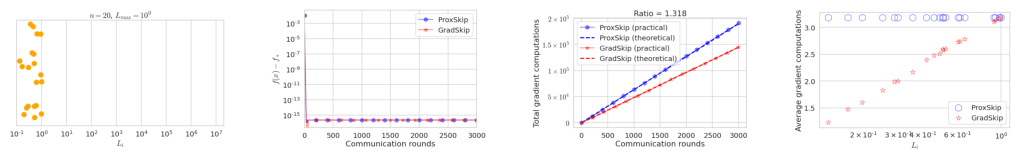

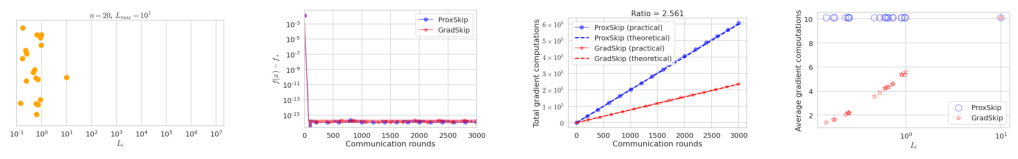

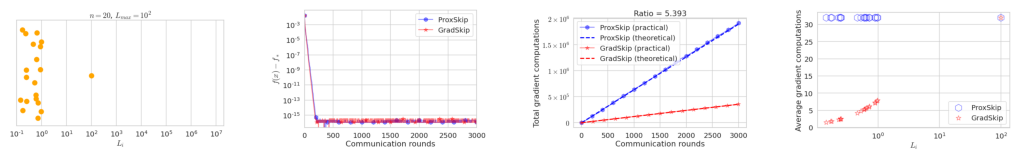

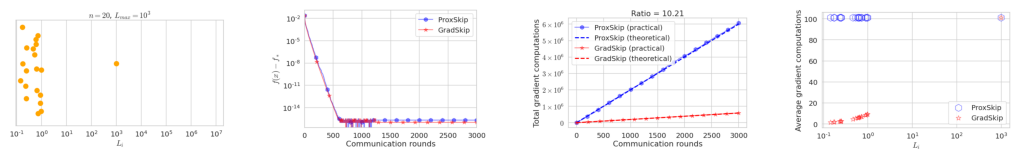

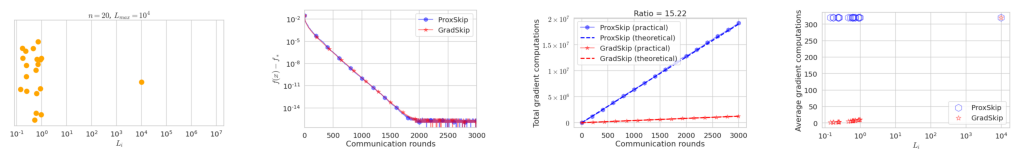

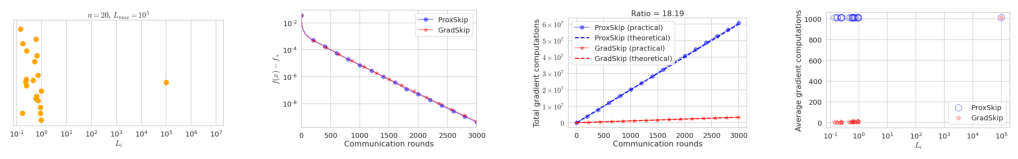

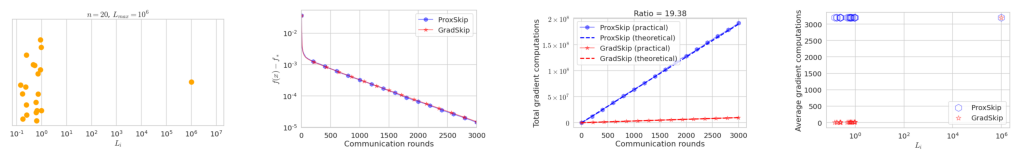

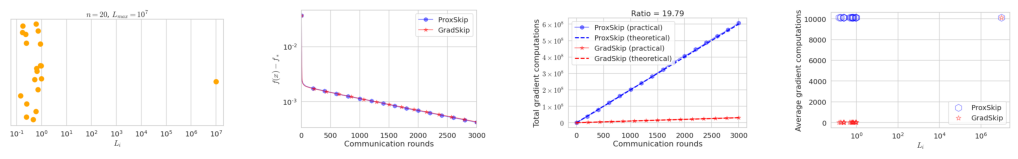

In [24]:
if it_max_L:
    prox_skip = get_prox_dict()
    grad_skip = get_grad_dict()
    L = get_L_dict()
        
    for l in L_maxes:    
        l = round(l)
        plot_strip(L=L[f'L_max={l}'], save_as=f'L_max={l}',
                  xticks=[l2_artificial,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7], xlim=[0,1e7+1e7],
                  size1=15, alpha=1, size2=15)
        plot_convergence(prox_skip=prox_skip[f'L_max={l}'], grad_skip=grad_skip[f'L_max={l}'], max_rounds=it_max_L, save_as=f'L_max={l}')
        plot_gap(prox_skip=prox_skip[f'L_max={l}'], grad_skip=grad_skip[f'L_max={l}'], max_rounds=it_max_L, L=L[f'L_max={l}'], save_as=f'L_max={l}')
        plot_avg(prox_skip=prox_skip[f'L_max={l}'], grad_skip=grad_skip[f'L_max={l}'], max_rounds=it_max_L, L=L[f'L_max={l}'], save_as=f'L_max={l}')
        
    # There must be a better way to do this!
    for l in L_maxes:
        l = round(l)
        plt.figure(figsize=(18,6))

        for i, plot in enumerate(['strip', 'conv', 'gap', 'avg']):
            image = mpimg.imread(f'./Experiments/{plot}_L_max={l}.png')
            plt.subplot(1,4,i+1)
            plt.imshow(image)
            plt.axis('off')

# Plot n

/var/folders/85/16bzmhwj69q5ml84_p5zhkvd0m4sgy/T/ipykernel_73684/2300611169.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(xlim)
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp s

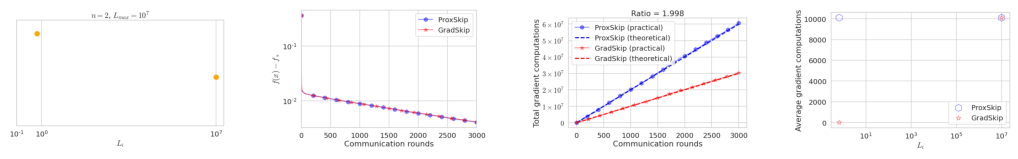

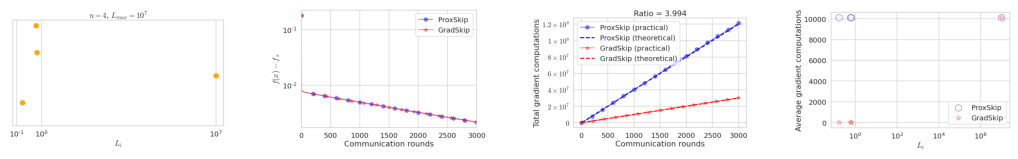

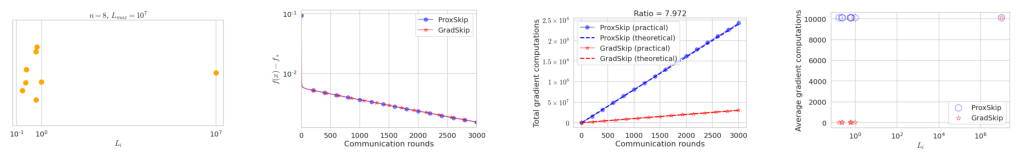

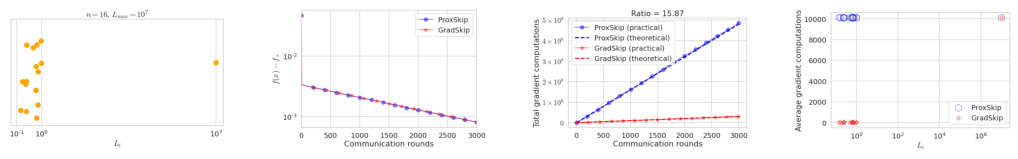

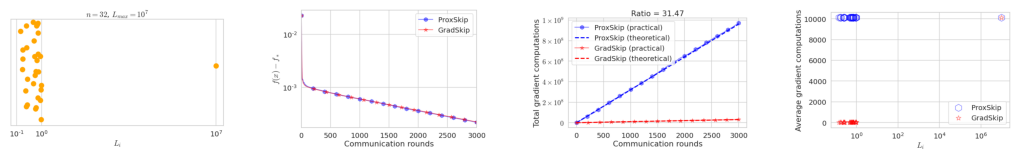

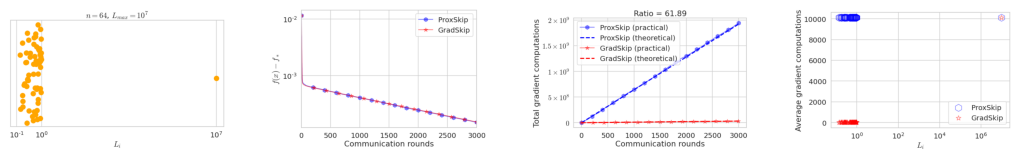

In [25]:
if it_max_n:
    prox_skip = get_prox_dict()
    grad_skip = get_grad_dict()
    L = get_L_dict()

    for n in ns:    
        plot_strip(L=L[n], save_as=n,
                  xticks=[l2_artificial,1e0,1e7], xlim=[0,1e7+1e7],
#                   size1=7, alpha=0.5, size2=15
                  size1=15, alpha=1, size2=15
                  )
        plot_convergence(prox_skip=prox_skip[n], grad_skip=grad_skip[n], max_rounds=it_max_n, save_as=n)
        plot_gap(prox_skip=prox_skip[n], grad_skip=grad_skip[n], max_rounds=it_max_n, L=L[n], save_as=n)
        plot_avg(prox_skip=prox_skip[n], grad_skip=grad_skip[n], max_rounds=it_max_n, L=L[n], save_as=n)
        
    # There must be a better way to do this!
    for n in ns:
        plt.figure(figsize=(18,6))

        for i, plot in enumerate(['strip', 'conv', 'gap', 'avg']):
            image = mpimg.imread(f'./Experiments/{plot}_{n}.png')
            plt.subplot(1,4,i+1)
            plt.imshow(image)
            plt.axis('off')

# Plot time

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
No artists with labels found to put in legend.  Note that artists whose label start with an under

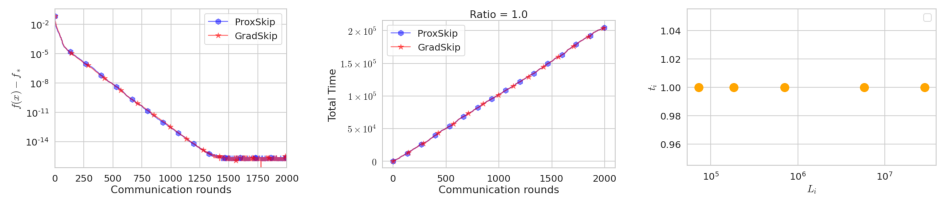

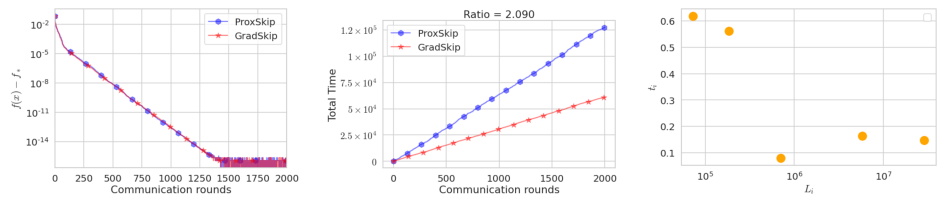

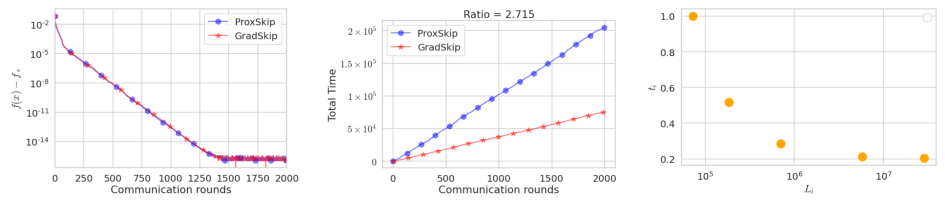

In [26]:
if it_max_time:
    prox_skip = get_prox_dict()
    grad_skip = get_grad_dict()
    L = get_L_dict()
    l2 = get_l2_dict()
    
    for key, grad_time in grad_times:  
        plot_scatter(L=L[key], key=key)
        plot_convergence(prox_skip=prox_skip[key], grad_skip=grad_skip[key], max_rounds=it_max_time, save_as=key)
        plot_time_gap(prox_skip=prox_skip[key], grad_skip=grad_skip[key], max_rounds=it_max_time, L=L[key], save_as=key, l2=l2[key])
        plot_L_time(L=L[key], grad_time=grad_time, l2=l2[key], save_as=key)

    for key, _ in grad_times:
        plt.figure(figsize=(18,6))
        for i, plot in enumerate(['scatter', 'conv', 'time_gap', 'L_time'][1:]):
            image = mpimg.imread(f'./Experiments/{plot}_{key}.png')
            plt.subplot(1,4,i+1)
            plt.imshow(image)
            plt.axis('off')
#             plt.title(key)
            plt.tight_layout()
